# Imports Needed

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle

### Read all files in Data/ into a File Array

In [2]:
def read_file_name():
    files = []
    for file in os.listdir('Data/'):
        files.append(file)
    return files

### Split the File Array into Different Arrays

In [3]:
def parse_files(files):
    """
    Description:
    Reads an array of filepaths
    
    Parameter:
    files (List[str]): filepath array
    
    Returns:
    Tuple: (string: acc_files, string: gscope_files)
    """
    acc_files = []
    gscope_files = []
    for file in files:
        parts = file.split('_')
        sensorName = parts[0]
        if sensorName == "Acc":
            acc_files.append(file)
        else:
            gscope_files.append(file)
    return acc_files, gscope_files

In [4]:
files = read_file_name()
acc_files, gscope_files = parse_files(files)

### Get File Data based on file format (sensortype_movement_type_recordingnumber)

In [5]:
def get_file_data(file):
    """
    Description:
    Helper function to get file data from a filepath
    
    Parameter:
    File is a string with the path to the file to get its data
    
    Returns:
    A triplet (string: sensor_type, string: movement_type, int: recording_number)
    """
    parts = file.split('_')
    sensor_type = parts[0]
    movement_type = parts[1]
    recording_number = int(parts[2].replace('.csv', ''))
    return sensor_type, movement_type, recording_number

### Function calls for above functions

In [6]:
def clean_dataframe(dataframe):
    clean_df = dataframe.iloc[100:-100]
    clean_df = clean_df.reset_index(drop=True)
    return clean_df

### Get a Merged dataframe within a certain class
### The merged data includes the accelerometer and gyroscope data

In [7]:
def get_completed_df(class_type: str, clean_data=False):
    """
    Description:
    Gets a merged dataframe of a certain class_type
    
    Parameter:
    class_type (str): Movement that is required to be merged into a dataframe from csv files
    
    Returns:
    complete_df (DataFrame): Dataframe with all files with the class_type specified merged together.
    """
    complete_df = pd.DataFrame()
    for index in range(len(acc_files)):
        file_data = get_file_data(acc_files[index])
        if(file_data[1] == class_type):
            acc_df = pd.read_csv("Data/" + acc_files[index], usecols=[1,2,3], names=['ax', 'ay', 'az'], skiprows=[0])
            gscope_df = pd.read_csv("Data/" + gscope_files[index], usecols=[1,2,3], names=['gx', 'gy', 'gz'], skiprows=[0])
            if clean_data:
                acc_df = clean_dataframe(acc_df)
                gscope_df = clean_dataframe(gscope_df)
                merged_df = pd.concat([acc_df, gscope_df], axis=1)
                complete_df = pd.concat([complete_df, merged_df], axis=0, ignore_index=True)
                complete_df["Class"] = class_type
            else:
                merged_df = pd.concat([acc_df, gscope_df], axis=1)
                complete_df = pd.concat([complete_df, merged_df], axis=0, ignore_index=True)
                complete_df["Class"] = class_type
    return complete_df

### Split the function into respective dataframes (training, test, and validation)

In [8]:
def split_dataframes(class_type: str, clean_data=False):
    """
    Description:
    Splits the complete dataframe based on the parameter passed
    
    Parameter:
    class_type (str): String of the movement type
    
    Returns:
    Triplet (train_df, test_df, validation_df): dataframes for each required set
    """
    if clean_data:
        complete_df = get_completed_df(class_type=class_type, clean_data=True)
    else:
        complete_df = get_completed_df(class_type=class_type)
        # get completely merged dataframe for a certain class
    # Returns 60% of the complete dataframe for the training data and 40% of the rest
    train_df, complement_df = train_test_split(complete_df, train_size = 0.6, shuffle = False)
    # Returns 50% of the complement dataframe for the test data and 50% for the validation data
    test_df, validation_df = train_test_split(complement_df, test_size = 0.5, shuffle = False)
    train_df = train_df.reset_index(drop=True).dropna()
    test_df = test_df.reset_index(drop=True).dropna()
    validation_df = validation_df.reset_index(drop=True).dropna()
    return train_df, test_df, validation_df

### Save and Pickle the dataframe into the specified directory

In [9]:
def save_and_pickle(dataframe, directory, subdirectory, class_type, is_cleaned=False):
    """
    Description:
    Saves and pickles a file to a specified directory
    
    Parameter:
    dataframe (pd.DataFrame()): Dataframe to be saved and pickled\n
    directory (str): Directory within the CWD\n
    subdirectory (str): subdirectory within the directory specified before\n
    """
    filename = f'{class_type}.pkl'
    dir_path = f"{directory}/{subdirectory}"
    os.makedirs(dir_path, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    pd.to_pickle(dataframe, filepath_or_buffer=filepath)

### Load and Unpickle the dataframe from the directory specified

In [10]:
def load_and_unpickle(class_type, directory, subdirectory):
    """
    Description:
    Loads and Unpickles a file from the supplied parameters
    
    Parameter:
    class_type (str): class type to be loaded and unpickled\n
    directory (str): directory within the CWD\n
    subdirectory (str): subdirectory within the directory specified\n
    
    Returns:
    Specified dataframe if found in the directory\n
    None if not found\n
    """
    dir_path = f"{directory}/{subdirectory}"
    filename = f'{class_type}.pkl'
    filepath = os.path.join(dir_path, filename)

    if os.path.exists(filepath):
        df = pd.read_pickle(filepath)
        print(f"Loaded from {subdirectory} for class {class_type}")
        return df
    else:
        print(f"File not found: {filepath}")
        return None

# Original Data

### Saving and pickling original dataframes

In [11]:
activities = ["Jump", "Run", "Walk", "Squat"]
df_arr_original = []
for index, activity in enumerate(activities):
    df_arr_original.append(split_dataframes(activity, clean_data=False))
    # print(df_arr_original[index][0].dtype)

for index, myTuple in enumerate(df_arr_original):
    for i in range(len(myTuple)):
        if i == 0:
            save_and_pickle(myTuple[i], "Original", "Training", class_type=activities[index])
        elif i == 1:
            save_and_pickle(myTuple[i], "Original", "Test", class_type=activities[index])
        else:
            save_and_pickle(myTuple[i], "Original", "Validation", class_type=activities[index])
    

### Plotting Combined Accelerometer and Gyroscope data for original training data (Time Plot)

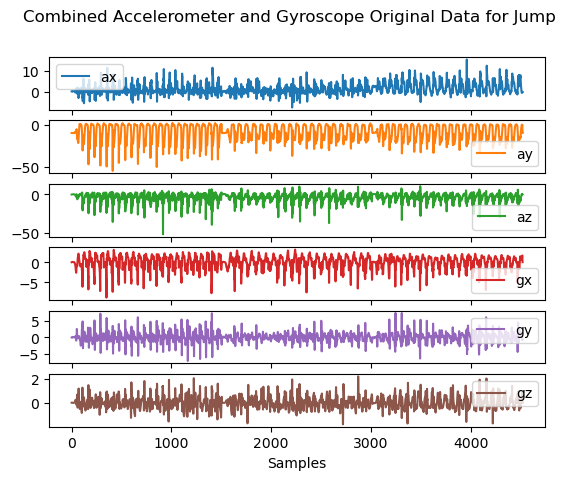

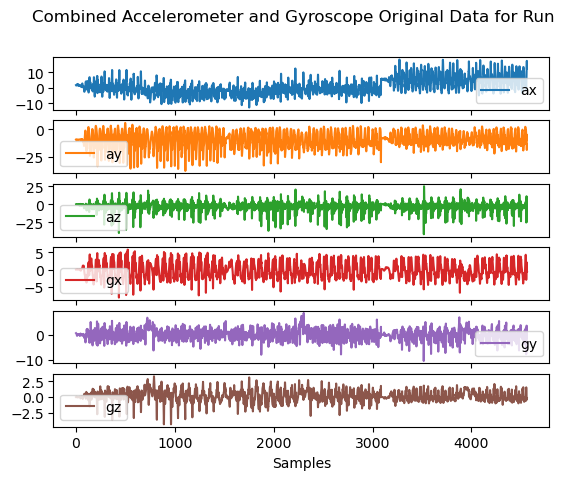

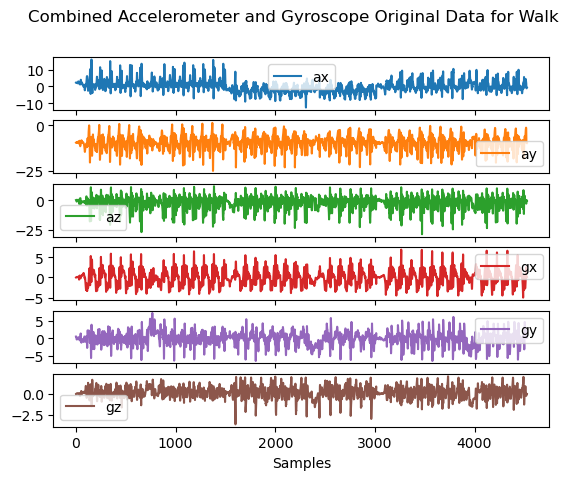

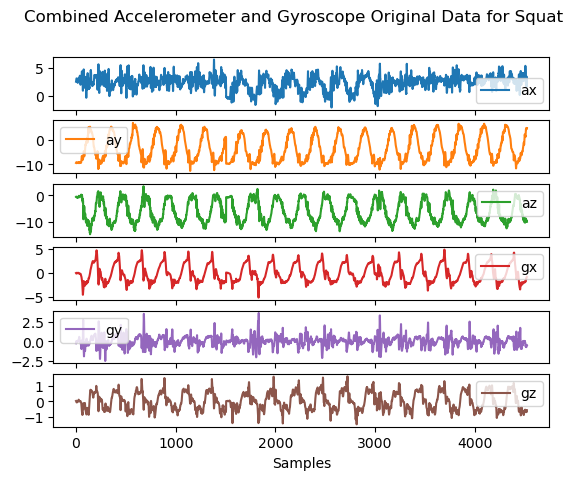

In [12]:
for index, myTuple in enumerate(df_arr_original):
    train_df = myTuple[0]
    title = f"Combined Accelerometer and Gyroscope Original Data for {activities[index]}"
    train_df.plot(subplots=True, title=title, xlabel="Samples")

### Describe() of the original training data

In [13]:
for index, myTuple in enumerate(df_arr_original):
    train_df = myTuple[0]
    print(f"Description of '{activities[index]}' original training dataframe:")
    summary = train_df.describe()
    print(summary)

Description of 'Jump' original training dataframe:
                ax           ay           az           gx           gy  \
count  4522.000000  4522.000000  4522.000000  4522.000000  4522.000000   
mean      1.236230    -8.984456    -3.800382    -0.010464    -0.005653   
std       2.373521     9.494449     5.024311     1.582580     1.349502   
min      -7.588919   -55.252502   -51.984198    -8.720119    -7.227653   
25%      -0.194745   -16.755220    -6.262826    -0.779503    -0.751619   
50%       0.531395    -6.802305    -2.878364     0.120388    -0.006150   
75%       2.343639    -0.170683     0.046553     1.128245     0.762898   
max      15.322886     2.298171    10.248887     3.088918     7.453288   

                gz  
count  4522.000000  
mean      0.024270  
std       0.476444  
min      -1.777599  
25%      -0.303289  
50%      -0.002657  
75%       0.295120  
max       2.219105  
Description of 'Run' original training dataframe:
                ax           ay           a

# Question

### Use the describe method for all four classes. What are the differences between all classes? What statistic measure is different for the classes?

Mean: "Jump" and "Squat" have higher mean values in ax. While "Run" and "Walk" have lower values, which reflect different movement intensity on the x-axis

Standard Deviation: "Run" has the highest variability across most axes, indicating more dynamic movement. While "Squat" shows lower variability in certain axes like gy, reflecting controlled motion.

### Plotting combined accelerometer and gyroscope data for original training data (box plot)

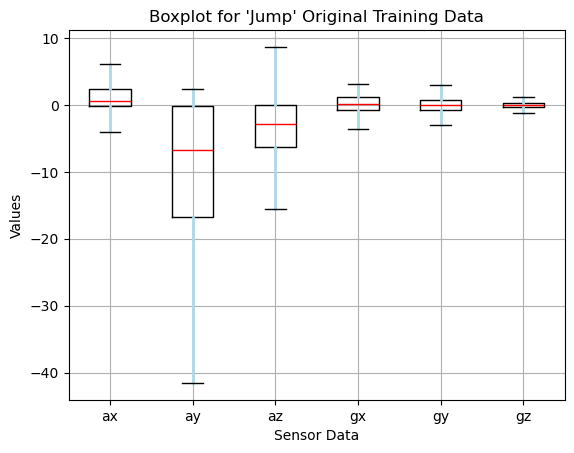

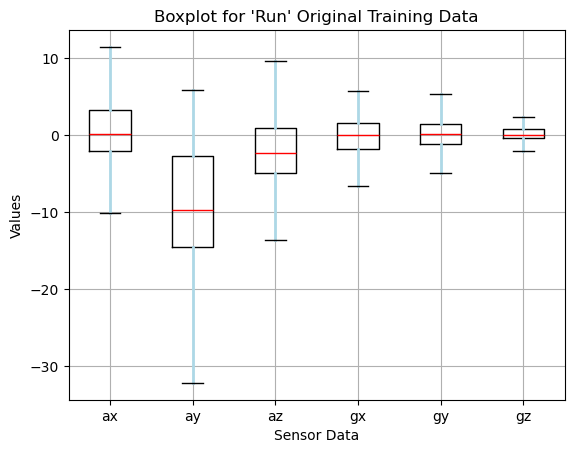

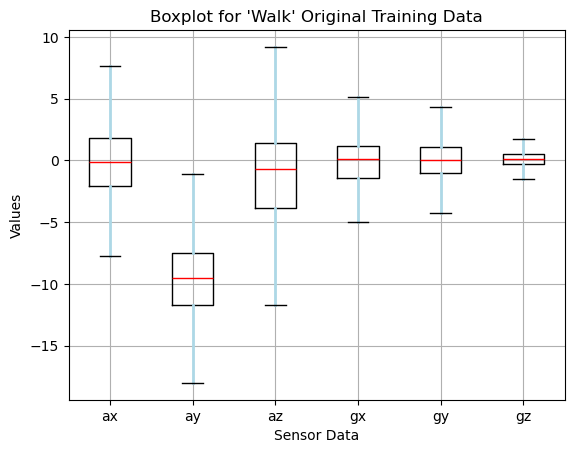

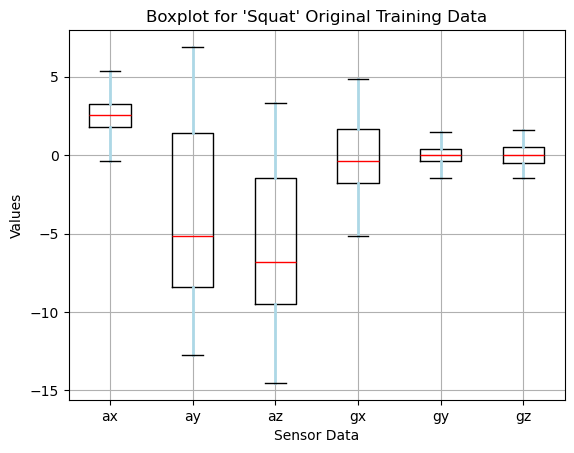

In [14]:
for index, myTuple in enumerate(df_arr_original):
    train_df = myTuple[0]
    title = f"Box plot of {activities[index]}"
    train_df.boxplot(
        boxprops=dict(color = 'black'),        # Box color
        medianprops=dict(color = 'red', linewidth = 1),  # Median line color
        whiskerprops=dict(color = 'lightblue', linewidth = 2),
        showfliers=False
    )
    plt.title(f"Boxplot for '{activities[index]}' Original Training Data")
    plt.xlabel("Sensor Data")
    plt.ylabel("Values")
    plt.show()

# Clean Data

### Saving and pickling clean dataframes

In [15]:
df_arr_clean = []
for activity in activities:
    df_arr_clean.append(split_dataframes(activity, clean_data=True))

for index, myTuple in enumerate(df_arr_clean):
    for i in range(len(myTuple)):
        if i == 0:
            save_and_pickle(myTuple[i], "Clean", "Training", class_type=activities[index], is_cleaned=True)
        elif i == 1:
            save_and_pickle(myTuple[i], "Clean", "Test", class_type=activities[index], is_cleaned=True)
        else:
            save_and_pickle(myTuple[i], "Clean", "Validation", class_type=activities[index], is_cleaned=True)

### Plotting Combined Accelerometer and Gyroscope data for clean training data (Time Plot)

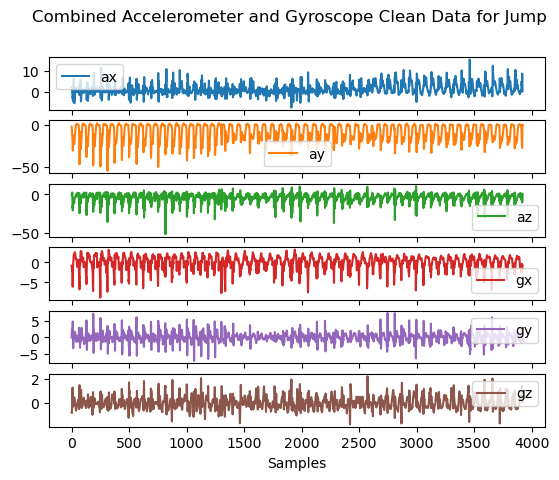

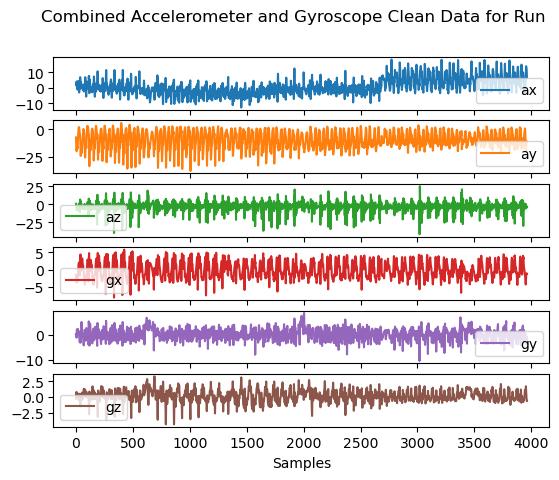

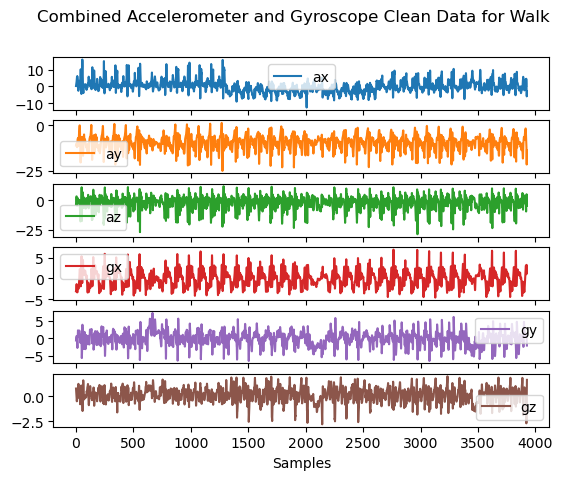

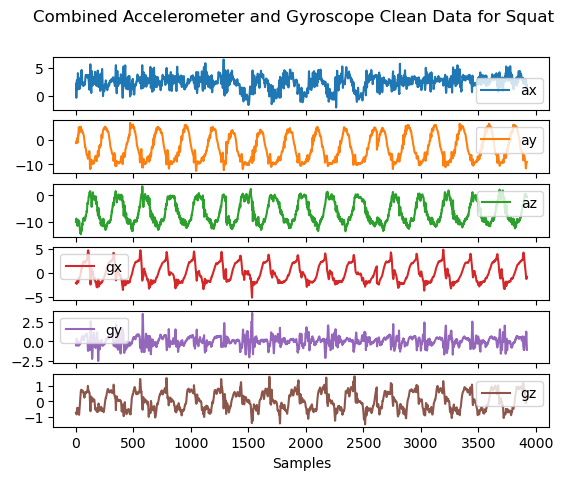

In [16]:
for index, myTuple in enumerate(df_arr_clean):
    train_df = myTuple[0]
    title = f"Combined Accelerometer and Gyroscope Clean Data for {activities[index]}"
    train_df.plot(subplots=True, title=title, xlabel="Samples")

### Describe() of the clean training data

In [17]:
for index, myTuple in enumerate(df_arr_clean):
    train_df = myTuple[0]
    print(f"Description of '{activities[index]}' clean training dataframe:")
    summary = train_df.describe()
    print(summary)

Description of 'Jump' clean training dataframe:
                ax           ay           az           gx           gy  \
count  3922.000000  3922.000000  3922.000000  3922.000000  3922.000000   
mean      1.228184    -8.994262    -3.954831    -0.003408    -0.002104   
std       2.398679     9.739656     5.130374     1.620287     1.376698   
min      -7.588919   -55.252502   -51.984198    -8.720119    -7.227653   
25%      -0.215140   -17.001271    -6.487771    -0.776426    -0.773849   
50%       0.524135    -5.591847    -3.068544     0.200143    -0.019187   
75%       2.362836    -0.112304     0.082142     1.144995     0.800810   
max      15.322886     2.298171    10.248887     3.088918     7.453288   

                gz  
count  3922.000000  
mean      0.023683  
std       0.488556  
min      -1.777599  
25%      -0.315006  
50%      -0.018984  
75%       0.304234  
max       2.219105  
Description of 'Run' clean training dataframe:
                ax           ay           az     

### Plotting combined accelerometer and gyroscope data for clean training data (box plot)

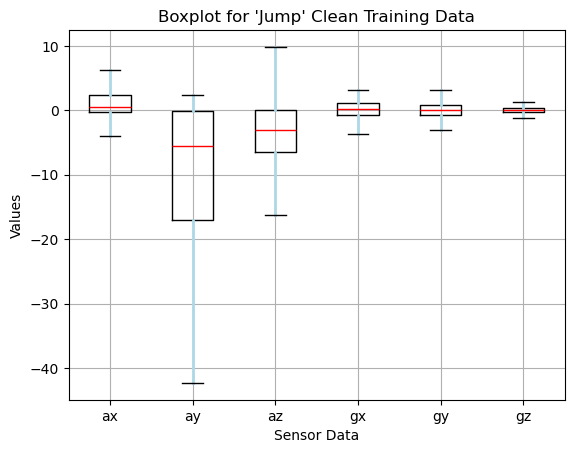

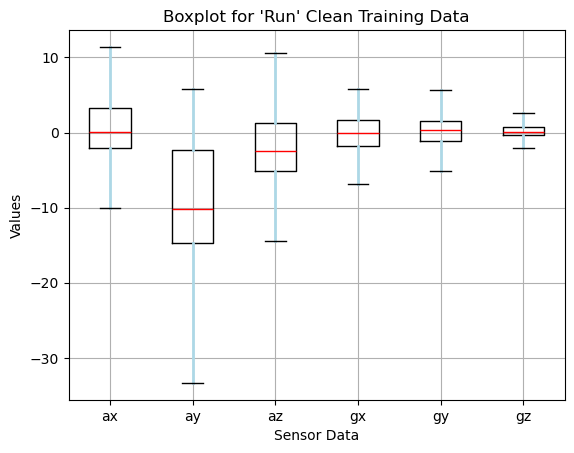

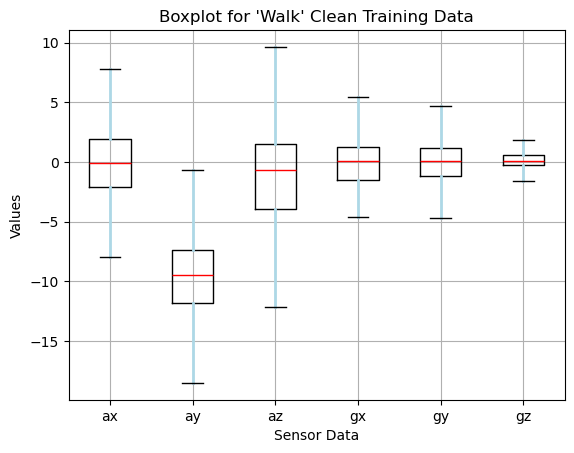

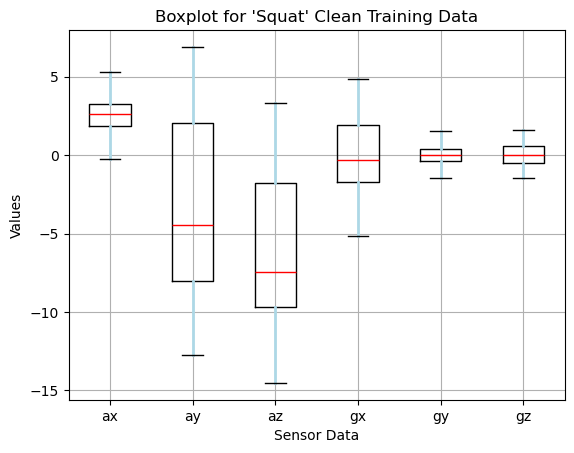

In [18]:
for index, myTuple in enumerate(df_arr_clean):
    train_df = myTuple[0]
    title = f"Box plot of {activities[index]}"
    train_df.boxplot(
        boxprops=dict(color = 'black'),        # Box color
        medianprops=dict(color = 'red', linewidth = 1),  # Median line color
        whiskerprops=dict(color = 'lightblue', linewidth = 2),
        showfliers=False
    )
    plt.title(f"Boxplot for '{activities[index]}' Clean Training Data")
    plt.xlabel("Sensor Data")
    plt.ylabel("Values")
    plt.show()

# Question

### Why do you have these irregularities in your recordings? Or maybe you do not, how come?

In my recordings, there were some irregularities in certain movements such as the run and walk. That is mostly due to the way the recordings were taken. A start timer of 3s was used before any recording took place.

Since running and walking weren't recorded in a straight line, I had to run/walk a certain distance and then run/walk back which caused a small disturbance in the data.

The start of each recording was not indicative of the movement itself due to the reaction time between the start timer going off and starting the movement.

### Use the describe moethod for all four classes. What are the differences between all classes? What statistic measure is different for the classes?

Mean: "Squat" has the highest mean in ax, while "Jump" and "Walk" have lower values, reflecting different movement intensities. "Run" shows more variability in the gyroscope values (gx, gy).

Standard Deviation: "Run" exhibits the highest variability in multiple axes (ax, gy), indicating dynamic movement. "Squat" has lower variability in some axes like gy, showing more controlled movement.